In [ ]:
# b3_iframe_full_extractor.py
import requests
import pandas as pd
import re
import time
import csv
from io import StringIO
from bs4 import BeautifulSoup

# Selenium imports
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import (
    StaleElementReferenceException,
    ElementClickInterceptedException,
    TimeoutException,
)



[debug] tentando URL: https://sistemaswebb3-listados.b3.com.br/indexPage/day/IBXX?language=en-us
[debug] tentando URL: https://sistemaswebb3-listados.b3.com.br/indexPage/day/IBRX100?language=en-us
[debug] tentando URL: https://sistemaswebb3-listados.b3.com.br/indexPage/day/IBRX-100?language=en-us
[debug] Selenium tentando: https://sistemaswebb3-listados.b3.com.br/indexPage/day/IBXX?language=en-us
[debug] selects encontrados: 2
[debug] ajustei page-size para 120
[debug] page0 count=97
[debug] detected page numbers: []
[debug] no numeric pages; trying next loop
[debug] salvou 97 tickers
✅ Extraído via Selenium. Tickers: 97
TOTAL TICKERS: 97
['ALOS3.SA', 'ABEV3.SA', 'ANIM3.SA', 'ASAI3.SA', 'AURE3.SA', 'AZZA3.SA', 'BBSE3.SA', 'BBDC3.SA', 'BBDC4.SA', 'BRAP4.SA', 'BBAS3.SA', 'BRKM5.SA', 'BRAV3.SA', 'BPAC11.SA', 'CXSE3.SA', 'CEAB3.SA', 'CMIG4.SA', 'COGN3.SA', 'CSMG3.SA', 'CPLE3.SA', 'CPLE6.SA', 'CSAN3.SA', 'CPFE3.SA', 'CMIN3.SA', 'CURY3.SA', 'CVCB3.SA', 'CYRE3.SA', 'DIRR3.SA', 'ECOR3.SA', 'EL

In [ ]:
TICKER_REGEX = re.compile(r'^[A-Z]{2,6}\d{1,2}$', re.I)
HEADER_KEYWORDS = {"code", "stock", "ativo", "código", "codigo", "symbol", "ticker"}

In [ ]:
def normalize_token(tok: str):
    if not isinstance(tok, str):
        return None
    s = tok.strip().upper().split()[0]
    s = re.sub(r'[^A-Z0-9]', '', s)
    if TICKER_REGEX.match(s):
        return s + '.SA'
    return None

In [ ]:

def try_download_csv_from_iframe(iframe_url, headers=None, timeout=10):
    """
    Tenta baixar CSV diretamente do conteúdo do iframe.
    Também procura na página por links que apontem para arquivos .csv (download).
    Retorna list de tickers se achou, senão None.
    """
    headers = headers or {"User-Agent": "Mozilla/5.0"}
    try:
        r = requests.get(iframe_url, headers=headers, timeout=timeout)
        r.raise_for_status()
    except Exception as e:
        print("requests ao iframe falhou:", e)
        return None

    # Se a resposta já for CSV (começa com "Code,"...), parse direto
    text = r.text
    if text.lstrip().startswith("Code,") or text.lstrip().splitlines()[0].lower().startswith("code,"):
        print("Encontrado CSV diretamente no iframe (conteúdo).")
        df = pd.read_csv(StringIO(text))
        if "Code" in df.columns or "code" in [c.lower() for c in df.columns]:
            col = next(c for c in df.columns if c.lower() == "code")
            tickers = [normalize_token(x) for x in df[col].astype(str)]
            tickers = [t for t in tickers if t]
            return list(dict.fromkeys(tickers))

    # Se HTML, procurar links <a> com href terminando em .csv ou com "composition"
    soup = BeautifulSoup(text, "lxml")
    links = soup.find_all("a", href=True)
    for a in links:
        href = a["href"]
        href_low = href.lower()
        # link relativo? montar absoluto
        if href_low.endswith(".csv") or "composition" in href_low and (".csv" in href_low or "download" in href_low or "composition" in href_low):
            # montar url absoluto se necessário
            if href.startswith("//"):
                href = "https:" + href
            elif href.startswith("/"):
                base = re.match(r'^(https?://[^/]+)', iframe_url)
                if base:
                    href = base.group(1) + href
            # tentar baixar
            try:
                rr = requests.get(href, headers=headers, timeout=timeout)
                rr.raise_for_status()
                txt = rr.text
                # tentar parsear CSV
                try:
                    df = pd.read_csv(StringIO(txt))
                except Exception:
                    # às vezes tem BOM ou encoding diferente
                    df = pd.read_csv(StringIO(txt.encode('utf-8').decode('utf-8', errors='ignore')))
                # detectar coluna de códigos
                col = None
                for c in df.columns:
                    if str(c).lower() in ("code","codigo","codigo ativo","codigo ativo","code "):
                        col = c; break
                if col is None:
                    # fallback: tentar primeira coluna
                    col = df.columns[0]
                tickers = [normalize_token(x) for x in df[col].astype(str)]
                tickers = [t for t in tickers if t]
                print(f"Download CSV via link bem-sucedido: {href}")
                return list(dict.fromkeys(tickers))
            except Exception as e:
                # continuar procurando outros links
                print("Falha ao baixar/parsar link csv:", href, e)
                continue
    return None

In [ ]:
# ---------------- Selenium robust pagination fallback ----------------
def selenium_extract_all_from_iframe(iframe_url, headless=True, wait_seconds=10, debug=False):
    options = Options()
    if headless:
        options.add_argument("--headless=new")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--window-size=1920,1200")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    try:
        driver.get(iframe_url)
        # esperar pela tabela (ou pelo conteúdo)
        try:
            WebDriverWait(driver, wait_seconds).until(EC.presence_of_element_located((By.TAG_NAME, "table")))
        except TimeoutException:
            time.sleep(1.5)

        # Scroll para baixo para expor selects/pagination
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(0.8)

        # 1) tentar selecionar a maior page-size usando o texto da opção (não o value)
        selects = driver.find_elements(By.TAG_NAME, "select")
        if debug: print(f"[debug] selects encontrados: {len(selects)}")
        made_change = False
        for sel in selects:
            try:
                opts = sel.find_elements(By.TAG_NAME, "option")
                numeric = []
                for o in opts:
                    txt = (o.text or "").strip()
                    # extrair número do texto (ex: "20", "20 per page", "Show 100")
                    m = re.search(r'(\d+)', txt)
                    if m:
                        n = int(m.group(1))
                        numeric.append((n, o))
                if numeric:
                    numeric_sorted = sorted(numeric, key=lambda x: x[0], reverse=True)
                    max_n, option_elem = numeric_sorted[0]
                    # clique com JS (mais robusto) ou normal click
                    try:
                        option_elem.click()
                    except Exception:
                        driver.execute_script("arguments[0].selected = true; arguments[0].dispatchEvent(new Event('change'))", option_elem)
                    if debug: print(f"[debug] ajustei page-size para {max_n}")
                    made_change = True
                    time.sleep(1.2)
                    break
            except StaleElementReferenceException:
                continue

        # função para extrair tickers da tabela visível
        def extract_current():
            html = driver.page_source
            soup = BeautifulSoup(html, "lxml")
            tables = soup.find_all("table")
            for table in tables:
                # identificar por cabeçalho
                ths = [th.get_text(" ", strip=True).lower() for th in table.find_all("th")]
                if not ths:
                    first_tr = table.find("tr")
                    if first_tr:
                        ths = [td.get_text(" ", strip=True).lower() for td in first_tr.find_all(["td","th"])]
                joined = " ".join(ths)
                if any(k in joined for k in HEADER_KEYWORDS):
                    # usar pandas para garantir consistência
                    try:
                        df = pd.read_html(StringIO(str(table)))[0]
                        # localizar melhor coluna de código
                        code_col = None
                        for c in df.columns:
                            if any(k in str(c).lower() for k in HEADER_KEYWORDS):
                                code_col = c; break
                        if code_col is None:
                            # heurística: coluna com mais matches
                            best_col = None; best_count = 0
                            for c in df.columns:
                                vals = df[c].astype(str).fillna('').tolist()
                                cnt = sum(1 for v in vals if normalize_token(v))
                                if cnt > best_count:
                                    best_count = cnt; best_col = c
                            code_col = best_col
                        if code_col is None:
                            continue
                        vals = [normalize_token(x) for x in df[code_col].astype(str)]
                        return [v for v in vals if v]
                    except Exception:
                        continue
            if tables:
                try:
                    df = pd.read_html(StringIO(str(tables[0])))[0]
                    best_col = None; best_count = 0
                    for c in df.columns:
                        vals = df[c].astype(str).fillna('').tolist()
                        cnt = sum(1 for v in vals if normalize_token(v))
                        if cnt > best_count:
                            best_count = cnt; best_col = c
                    if best_col is not None:
                        vals = [normalize_token(x) for x in df[best_col].astype(str)]
                        return [v for v in vals if v]
                except Exception:
                    pass
            return []

        collected = []
        seen = set()

        # extrair página inicial
        page0 = extract_current()
        if debug: print(f"[debug] page0 count={len(page0)}")
        for t in page0:
            if t not in seen:
                seen.add(t); collected.append(t)

        # 2) tentar localizar paginação numerada
        # procurar por elementos comuns (li.paginate_button, a.page-link, ul.pagination li a)
        page_numbers = set()
        try:
            els = driver.find_elements(By.CSS_SELECTOR, "ul.pagination li, div.pagination li, nav.pagination li")
            for li in els:
                try:
                    a = li.find_element(By.TAG_NAME, "a")
                    txt = (a.text or "").strip()
                    if txt.isdigit():
                        page_numbers.add(int(txt))
                except Exception:
                    continue
        except Exception:
            pass

        try:
            anchors = driver.find_elements(By.TAG_NAME, "a")
            for a in anchors:
                try:
                    txt = (a.text or "").strip()
                    if txt.isdigit():
                        page_numbers.add(int(txt))
                except Exception:
                    continue
        except Exception:
            pass

        page_numbers = sorted(page_numbers)
        if debug: print(f"[debug] detected page numbers: {page_numbers}")

        # se achou números, iterar por eles
        if page_numbers:
            for p in page_numbers:
                if p == 1:
                    continue
                anchors = driver.find_elements(By.TAG_NAME, "a")
                clicked = False
                for a in anchors:
                    try:
                        txt = (a.text or "").strip()
                        if txt == str(p):
                            try:
                                a.click()
                            except (ElementClickInterceptedException, StaleElementReferenceException):
                                driver.execute_script("arguments[0].click();", a)
                            # aguardar nova tabela
                            try:
                                WebDriverWait(driver, wait_seconds).until(EC.presence_of_element_located((By.TAG_NAME, "table")))
                            except Exception:
                                time.sleep(0.8)
                            time.sleep(0.5)
                            new = extract_current()
                            if debug: print(f"[debug] page {p} got {len(new)}")
                            for t in new:
                                if t not in seen:
                                    seen.add(t); collected.append(t)
                            clicked = True
                            break
                    except StaleElementReferenceException:
                        continue
                if not clicked and debug:
                    print(f"[debug] could not click page {p}")

        else:
            # se não há botões numerados, tentar clicar repetidamente em "next"
            if debug: print("[debug] no numeric pages; trying next loop")
            while True:
                found_next = None
                anchors = driver.find_elements(By.TAG_NAME, "a")
                for a in anchors:
                    try:
                        txt = (a.text or "").strip().lower()
                        if txt in (">", "»", "next", "próximo", "proximo"):
                            found_next = a
                            break
                    except Exception:
                        continue
                if not found_next:
                    break
                try:
                    found_next.click()
                except (ElementClickInterceptedException, StaleElementReferenceException):
                    driver.execute_script("arguments[0].click();", found_next)
                try:
                    WebDriverWait(driver, wait_seconds).until(EC.presence_of_element_located((By.TAG_NAME, "table")))
                except Exception:
                    time.sleep(0.8)
                time.sleep(0.4)
                new = extract_current()
                added = 0
                for t in new:
                    if t not in seen:
                        seen.add(t); collected.append(t); added += 1
                if debug: print(f"[debug] next loop added {added}")
                if added == 0:
                    break

        # salvar CSV e retornar
        if collected:
            with open("tickers_ibrx100_full.csv", "w", newline="", encoding="utf-8") as f:
                writer = csv.writer(f)
                writer.writerow(["Ticker"])
                for t in collected:
                    writer.writerow([t])
            if debug: print(f"[debug] salvou {len(collected)} tickers")
            return collected
        else:
            return None

    finally:
        driver.quit()

In [ ]:
# -------------- Orquestração --------------
def get_all_ibrx100_tickers(iframe_src="https://sistemaswebb3-listados.b3.com.br/indexPage/day/IBXX?language=en-us", try_index_codes=None, use_selenium_fallback=True, debug=False):
    """
    Tenta baixar CSV direto; se não, tenta requests/parsing; se não, usa Selenium para paginação.
    try_index_codes: lista de strings para substituir 'IBXX' placeholder (ex: ['IBRX100'])
    """
    headers = {"User-Agent": "Mozilla/5.0"}
    urls_to_try = [iframe_src]
    if try_index_codes:
        for code in try_index_codes:
            urls_to_try.append(iframe_src.replace("IBXX", code))
    for url in urls_to_try:
        if debug: print("[debug] tentando URL:", url)
        try:
            tickers = try_download_csv_from_iframe(url, headers=headers)
            if tickers:
                print("✅ Extraído via download/parsing direto. Tickers:", len(tickers))
                return tickers
        except Exception as e:
            if debug: print("requests parse falhou:", e)
            pass

    # 2) fallback: Selenium
    if use_selenium_fallback:
        for url in urls_to_try:
            try:
                if debug: print("[debug] Selenium tentando:", url)
                res = selenium_extract_all_from_iframe(url, headless=not debug, wait_seconds=12, debug=debug)
                if res:
                    print("✅ Extraído via Selenium. Tickers:", len(res))
                    return res
            except Exception as e:
                if debug: print("Selenium tentativa falhou:", e)
                continue

    print("⚠️ Não foi possível extrair tickers por nenhum método.")
    return []

# USO
if __name__ == "__main__":
    # passe try_index_codes para substituir IBXX por IBRX100 se necessário
    tickers = get_all_ibrx100_tickers(
        iframe_src="https://sistemaswebb3-listados.b3.com.br/indexPage/day/IBXX?language=en-us",
        try_index_codes=["IBRX100","IBRX-100"],
        use_selenium_fallback=True,
        debug=True  # define False para headless e menos logs
    )
    print("TOTAL TICKERS:", len(tickers))
    print(tickers)

In [57]:
"""
download_histories.py

Uso:
- coloque a lista de tickers (formato ex: 'ABEV3.SA') em `tickers`.
- execute este script: python download_histories.py
- os arquivos serão salvos em ./data/historical/<TICKER>.parquet e ./data/historical/<TICKER>.csv
"""

import os
import time
import logging
from datetime import datetime
from typing import List, Dict, Optional
import pandas as pd
import yfinance as yf
from tqdm import tqdm
import traceback

# logging simples
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

# diretório onde os históricos serão salvos (compatível com seu script anterior)
HIST_DIR = os.path.join("data", "historical")
os.makedirs(HIST_DIR, exist_ok=True)

# parâmetros de download
DEFAULT_START = "1998-01-01"
BATCH_SIZE = 15            # número de tickers por chamada yfinance.download (ajuste se achar necessário)
MAX_ATTEMPTS = 4           # tentativas por batch
SLEEP_BETWEEN_BATCHES = 1  # segundos entre batches para reduzir risco de throttling
SLEEP_BETWEEN_TICKERS = 0.2

def ticker_exists_local(ticker: str) -> bool:
    """Verifica se já existe parquet salvo para ticker (usa para pular downloads)"""
    path = os.path.join(HIST_DIR, f"{ticker}.parquet")
    return os.path.isfile(path)

def save_history_df(ticker: str, df: pd.DataFrame, save_csv: bool = True):
    """Salva DataFrame em parquet e opcionalmente em CSV. Garante coluna 'date' se índice for DatetimeIndex."""
    if df is None or df.empty:
        raise ValueError("DataFrame nulo ou vazio")
    df = df.copy()
    # garantir que a coluna de data exista como coluna
    if isinstance(df.index, pd.DatetimeIndex):
        df.index.name = "date"
        df = df.reset_index()
    # converter coluna date para string ISO ao salvar CSV (mantém compatibilidade)
    out_parquet = os.path.join(HIST_DIR, f"{ticker}.parquet")
    out_csv = os.path.join(HIST_DIR, f"{ticker}.csv")
    try:
        df.to_parquet(out_parquet, index=False)
        logging.info("Saved %s rows for %s -> %s", len(df), ticker, out_parquet)
    except Exception as e:
        logging.exception("Erro salvando parquet para %s: %s", ticker, e)
        raise
    if save_csv:
        try:
            # padronizar data para ISO antes de salvar CSV (se existir)
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
            df.to_csv(out_csv, index=False)
            logging.info("Saved CSV for %s -> %s", ticker, out_csv)
        except Exception as e:
            logging.exception("Erro salvando CSV para %s: %s", ticker, e)
            # não raise — parquet já salvo, apenas logamos o problema

def download_batch(batch: List[str], start: str = DEFAULT_START, threads: bool = True) -> Dict[str, Optional[pd.DataFrame]]:
    """
    Tenta baixar um batch de tickers via yfinance.download.
    Retorna dict ticker -> DataFrame or None (se falhou).
    """
    joined = " ".join(batch)
    attempt = 0
    last_exc = None
    while attempt < MAX_ATTEMPTS:
        try:
            logging.info("yfinance.download attempt %d for batch size %d", attempt+1, len(batch))
            data = yf.download(tickers=joined, start=start, progress=False, threads=threads, group_by='ticker', auto_adjust=False, actions=True)
            result = {}
            if isinstance(data, pd.DataFrame) and isinstance(data.columns, pd.MultiIndex):
                for ticker in batch:
                    if ticker in data.columns.get_level_values(0):
                        df_t = data[ticker].copy()
                        result[ticker] = df_t
                    else:
                        try:
                            single = yf.download(ticker, start=start, progress=False, actions=True)
                            result[ticker] = single if not single.empty else None
                        except Exception:
                            result[ticker] = None
            else:
                for ticker in batch:
                    try:
                        df_t = yf.download(ticker, start=start, progress=False, actions=True)
                        result[ticker] = df_t if not df_t.empty else None
                    except Exception:
                        result[ticker] = None
            return result
        except Exception as e:
            last_exc = e
            logging.warning("Erro no yfinance.download (attempt %d): %s", attempt+1, str(e))
            attempt += 1
            time.sleep(2 ** attempt)  # backoff exponencial
    logging.error("Todas tentativas falharam para batch (%s). Último erro: %s", joined, last_exc)
    # fallback: tentar baixar ticker a ticker
    result = {}
    for ticker in batch:
        try:
            df_t = yf.download(ticker, start=start, progress=False, actions=True)
            result[ticker] = df_t if not df_t.empty else None
        except Exception as e:
            logging.warning("Fallback individual falhou para %s: %s", ticker, e)
            result[ticker] = None
    return result

def download_all_histories(tickers: List[str], start: str = DEFAULT_START, force: bool = False, save_summary: bool = True, save_csv_per_ticker: bool = True):
    """
    Processo principal: recebe lista de tickers (strings), baixa históricos e salva parquet + csv por ticker.
    - force: se True, re-baixa mesmo que arquivo exista.
    - save_csv_per_ticker: se True salva um CSV para cada ticker (além do parquet).
    - retorna um DataFrame resumo com status por ticker.
    """
    os.makedirs(HIST_DIR, exist_ok=True)
    tickers = [t for t in tickers if isinstance(t, str) and t.strip()]
    tickers = list(dict.fromkeys(tickers))
    summary = []
    for i in range(0, len(tickers), BATCH_SIZE):
        batch = tickers[i:i+BATCH_SIZE]
        to_download = [t for t in batch if force or not ticker_exists_local(t)]
        if not to_download:
            logging.info("Batch %d: todos já existem localmente — pulando.", i//BATCH_SIZE+1)
            for t in batch:
                summary.append({
                    "ticker": t,
                    "status": "skipped_local",
                    "rows": None,
                    "saved_parquet": os.path.join(HIST_DIR, f"{t}.parquet") if ticker_exists_local(t) else None,
                    "saved_csv": os.path.join(HIST_DIR, f"{t}.csv") if os.path.exists(os.path.join(HIST_DIR, f"{t}.csv")) else None
                })
            continue

        logging.info("Processando batch %d/%d (download %d/%d)", i//BATCH_SIZE+1, (len(tickers)+BATCH_SIZE-1)//BATCH_SIZE, len(to_download), len(batch))
        results = download_batch(to_download, start=start)
        for t in batch:
            df_t = results.get(t) if t in results else None
            if df_t is None or (isinstance(df_t, pd.DataFrame) and df_t.empty):
                logging.warning("Nenhum dado para %s em batch; tentativa isolada...", t)
                try:
                    single = yf.download(t, start=start, progress=False, actions=True)
                    df_t = single if not single.empty else None
                except Exception:
                    df_t = None
            if df_t is None or df_t.empty:
                logging.error("Falha obtendo dados para %s", t)
                summary.append({"ticker": t, "status": "failed", "rows": 0, "saved_parquet": None, "saved_csv": None})
            else:
                try:
                    save_history_df(t, df_t, save_csv=save_csv_per_ticker)
                    summary.append({
                        "ticker": t,
                        "status": "ok",
                        "rows": len(df_t),
                        "saved_parquet": os.path.join(HIST_DIR, f"{t}.parquet"),
                        "saved_csv": os.path.join(HIST_DIR, f"{t}.csv") if save_csv_per_ticker else None
                    })
                except Exception as e:
                    logging.exception("Erro salvando para %s: %s", t, e)
                    summary.append({"ticker": t, "status": "save_error", "rows": len(df_t) if isinstance(df_t, pd.DataFrame) else None, "saved_parquet": None, "saved_csv": None})
            time.sleep(SLEEP_BETWEEN_TICKERS)
        time.sleep(SLEEP_BETWEEN_BATCHES)

    df_summary = pd.DataFrame(summary)
    if save_summary:
        ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
        summary_path = os.path.join(HIST_DIR, f"download_summary_{ts}.csv")
        df_summary.to_csv(summary_path, index=False)
        logging.info("Resumo salvo em %s", summary_path)
    return df_summary

# utilitário para recombinar todos os parquets em um único arquivo (long format)
def combine_all_to_single_parquet(out_path: str = os.path.join(HIST_DIR, "all_histories.parquet"), out_csv: Optional[str] = os.path.join(HIST_DIR, "all_histories.csv"), tickers: Optional[List[str]] = None):
    """
    Lê todos os parquets em HIST_DIR (ou tickers list) e concatena em formato long:
    columns: ['ticker','date', 'Open','High','Low','Close','Adj Close','Volume', 'Dividends','Stock Splits']
    Salva em parquet e opcionalmente em csv.
    """
    files = []
    if tickers:
        files = [os.path.join(HIST_DIR, f"{t}.parquet") for t in tickers if os.path.exists(os.path.join(HIST_DIR, f"{t}.parquet"))]
    else:
        files = [os.path.join(HIST_DIR, f) for f in os.listdir(HIST_DIR) if f.endswith(".parquet")]
    dfs = []
    for f in files:
        try:
            df = pd.read_parquet(f)
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'])
            fname = os.path.basename(f).replace(".parquet","")
            if 'ticker' not in df.columns:
                df.insert(0, 'ticker', fname)
            dfs.append(df)
        except Exception as e:
            logging.warning("Erro lendo %s: %s", f, e)
    if not dfs:
        raise RuntimeError("Nenhum parquet encontrado para combinar.")
    big = pd.concat(dfs, ignore_index=True, sort=False)
    big.to_parquet(out_path, index=False)
    logging.info("Combined saved to %s (rows=%d)", out_path, len(big))
    if out_csv:
        try:
            # converter date para formato iso ao salvar CSV
            if 'date' in big.columns:
                big['date'] = pd.to_datetime(big['date']).dt.strftime('%Y-%m-%d')
            big.to_csv(out_csv, index=False)
            logging.info("Combined CSV saved to %s", out_csv)
        except Exception as e:
            logging.exception("Erro salvando combined CSV: %s", e)
    return big

# ------------------------------
# Exemplo de uso
# ------------------------------
if __name__ == "__main__":
    # 1) carregue a lista de tickers a partir do arquivo que você já salvou
    tickers_file = os.path.join("tickers_ibrx100_full.csv")
    if os.path.exists(tickers_file):
        df = pd.read_csv(tickers_file)
        if 'Ticker' in df.columns:
            tickers = df['Ticker'].dropna().astype(str).tolist()
        else:
            tickers = df.iloc[:,0].dropna().astype(str).tolist()
    else:
        raise RuntimeError(f"Não encontrou {tickers_file}. Coloque seu CSV de tickers no mesmo diretório ou edite este script.")

    # 2) opção: validar/normalizar tickers (garantir sufixo .SA)
    def normalize(t):
        t = str(t).strip().upper()
        if not t.endswith(".SA"):
            t = t.replace(".SA","") + ".SA"
        return t
    tickers = [normalize(t) for t in tickers]
    print("Tickers a baixar:", len(tickers), tickers[:10])

    # 3) executar (force=True re-baixa mesmo se já existir)
    summary_df = download_all_histories(tickers, start=DEFAULT_START, force=False, save_summary=True, save_csv_per_ticker=True)
    print(summary_df.head(50))

    # 4) opcional: combinar tudo em um único parquet e CSV (pode ser grande)
    combined = combine_all_to_single_parquet()
    print("Combined rows:", len(combined))


2025-10-15 15:06:38,252 INFO Processando batch 1/7 (download 15/15)
2025-10-15 15:06:38,265 INFO yfinance.download attempt 1 for batch size 15


Tickers a baixar: 97 ['ALOS3.SA', 'ABEV3.SA', 'ANIM3.SA', 'ASAI3.SA', 'AURE3.SA', 'AZZA3.SA', 'BBSE3.SA', 'BBDC3.SA', 'BBDC4.SA', 'BRAP4.SA']


2025-10-15 15:06:42,230 INFO Saved 6476 rows for ALOS3.SA -> data\historical\ALOS3.SA.parquet
2025-10-15 15:06:42,364 INFO Saved CSV for ALOS3.SA -> data\historical\ALOS3.SA.csv
2025-10-15 15:06:42,585 INFO Saved 6476 rows for ABEV3.SA -> data\historical\ABEV3.SA.parquet
2025-10-15 15:06:42,696 INFO Saved CSV for ABEV3.SA -> data\historical\ABEV3.SA.csv
2025-10-15 15:06:42,918 INFO Saved 6476 rows for ANIM3.SA -> data\historical\ANIM3.SA.parquet
2025-10-15 15:06:43,000 INFO Saved CSV for ANIM3.SA -> data\historical\ANIM3.SA.csv
2025-10-15 15:06:43,218 INFO Saved 6476 rows for ASAI3.SA -> data\historical\ASAI3.SA.parquet
2025-10-15 15:06:43,297 INFO Saved CSV for ASAI3.SA -> data\historical\ASAI3.SA.csv
2025-10-15 15:06:43,520 INFO Saved 6476 rows for AURE3.SA -> data\historical\AURE3.SA.parquet
2025-10-15 15:06:43,590 INFO Saved CSV for AURE3.SA -> data\historical\AURE3.SA.csv
2025-10-15 15:06:43,804 INFO Saved 6476 rows for AZZA3.SA -> data\historical\AZZA3.SA.parquet
2025-10-15 15:06

       ticker status  rows                      saved_parquet  \
0    ALOS3.SA     ok  6476   data\historical\ALOS3.SA.parquet   
1    ABEV3.SA     ok  6476   data\historical\ABEV3.SA.parquet   
2    ANIM3.SA     ok  6476   data\historical\ANIM3.SA.parquet   
3    ASAI3.SA     ok  6476   data\historical\ASAI3.SA.parquet   
4    AURE3.SA     ok  6476   data\historical\AURE3.SA.parquet   
5    AZZA3.SA     ok  6476   data\historical\AZZA3.SA.parquet   
6    BBSE3.SA     ok  6476   data\historical\BBSE3.SA.parquet   
7    BBDC3.SA     ok  6476   data\historical\BBDC3.SA.parquet   
8    BBDC4.SA     ok  6476   data\historical\BBDC4.SA.parquet   
9    BRAP4.SA     ok  6476   data\historical\BRAP4.SA.parquet   
10   BBAS3.SA     ok  6476   data\historical\BBAS3.SA.parquet   
11   BRKM5.SA     ok  6476   data\historical\BRKM5.SA.parquet   
12   BRAV3.SA     ok  6476   data\historical\BRAV3.SA.parquet   
13  BPAC11.SA     ok  6476  data\historical\BPAC11.SA.parquet   
14   CXSE3.SA     ok  647

2025-10-15 15:07:38,848 INFO Combined saved to data\historical\all_histories.parquet (rows=628172)
2025-10-15 15:07:45,123 INFO Combined CSV saved to data\historical\all_histories.csv


Combined rows: 628172


Lendo parquets: 100%|██████████| 97/97 [00:02<00:00, 47.64it/s]


,file,ticker,rows,start,end
0,ABEV3.SA.parquet,ABEV3.SA,6475,2000-01-03,2025-10-14
1,ALOS3.SA.parquet,ALOS3.SA,6475,2000-01-03,2025-10-14
2,ANIM3.SA.parquet,ANIM3.SA,6475,2000-01-03,2025-10-14
3,ASAI3.SA.parquet,ASAI3.SA,6475,2000-01-03,2025-10-14
4,AURE3.SA.parquet,AURE3.SA,6475,2000-01-03,2025-10-14
5,AZZA3.SA.parquet,AZZA3.SA,6475,2000-01-03,2025-10-14
6,BBAS3.SA.parquet,BBAS3.SA,6475,2000-01-03,2025-10-14
7,BBDC3.SA.parquet,BBDC3.SA,6475,2000-01-03,2025-10-14
8,BBDC4.SA.parquet,BBDC4.SA,6475,2000-01-03,2025-10-14
9,BBSE3.SA.parquet,BBSE3.SA,6475,2000-01-03,2025-10-14


Total rows combined: 628075
Tickers combinados: 97


,ticker,first,last,nrows,period_days
0,ABEV3.SA,2000-01-03,2025-10-14,6475,9416
1,ALOS3.SA,2000-01-03,2025-10-14,6475,9416
2,ANIM3.SA,2000-01-03,2025-10-14,6475,9416
3,ASAI3.SA,2000-01-03,2025-10-14,6475,9416
4,AURE3.SA,2000-01-03,2025-10-14,6475,9416
5,AZZA3.SA,2000-01-03,2025-10-14,6475,9416
6,BBAS3.SA,2000-01-03,2025-10-14,6475,9416
7,BBDC3.SA,2000-01-03,2025-10-14,6475,9416
8,BBDC4.SA,2000-01-03,2025-10-14,6475,9416
9,BBSE3.SA,2000-01-03,2025-10-14,6475,9416


Missing (global):
Open            230580
High            230580
Volume          230580
Low             230580
Close           230580
Adj Close       230580
Stock Splits    230580
Dividends       230580
date                 0
ticker               0
dtype: int64


C:\Users\kaike\AppData\Local\Temp\ipykernel_2592\1833096288.py:135: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['ret_daily'] = df.groupby('ticker')['price_used'].pct_change()
C:\Users\kaike\AppData\Local\Temp\ipykernel_2592\1833096288.py:139: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['ret_1d_forward'] = df.groupby('ticker')['price_used'].pct_change(periods=-1) * -1  # simpler to compute later if needed
C:\Users\kaike\AppData\Local\Temp\ipykernel_2592\1833096288.py:176: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use o

,ticker,n_obs,first,last,cagr,ann_return,ann_vol,sharpe,max_drawdown
69,RADL3.SA,6472,2000-01-06,2025-10-14,0.380822,0.610910,0.841870,0.725658,-0.623754
25,CURY3.SA,1262,2020-09-21,2025-10-14,0.356296,0.469278,0.391871,1.197531,-0.473148
11,BPAC11.SA,2152,2017-02-24,2025-10-14,0.352607,0.492482,0.435749,1.130195,-0.680142
49,ISAE4.SA,6426,2000-01-03,2025-10-14,0.315312,0.422311,0.392785,1.075169,-0.662012
19,CPFE3.SA,6475,2000-01-03,2025-10-14,0.255281,1.516271,3.603581,0.420768,-0.628743
95,WEGE3.SA,6475,2000-01-03,2025-10-14,0.251231,0.321061,0.331544,0.968381,-0.641985
75,RENT3.SA,5076,2005-05-23,2025-10-14,0.207686,0.324912,0.425716,0.763213,-0.767709
28,CYRE3.SA,6475,2000-01-03,2025-10-14,0.190039,0.338151,0.491055,0.688622,-0.809836
87,TOTS3.SA,4874,2006-03-09,2025-10-14,0.182423,0.266116,0.363732,0.731626,-0.497133
68,PSSA3.SA,5201,2004-11-22,2025-10-14,0.180839,0.237962,0.301045,0.790454,-0.622642


C:\Users\kaike\AppData\Local\Temp\ipykernel_2592\1833096288.py:205: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_groups = pivot.resample('M').last().index
C:\Users\kaike\AppData\Local\Temp\ipykernel_2592\1833096288.py:245: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_close = pivot.resample('M').last()


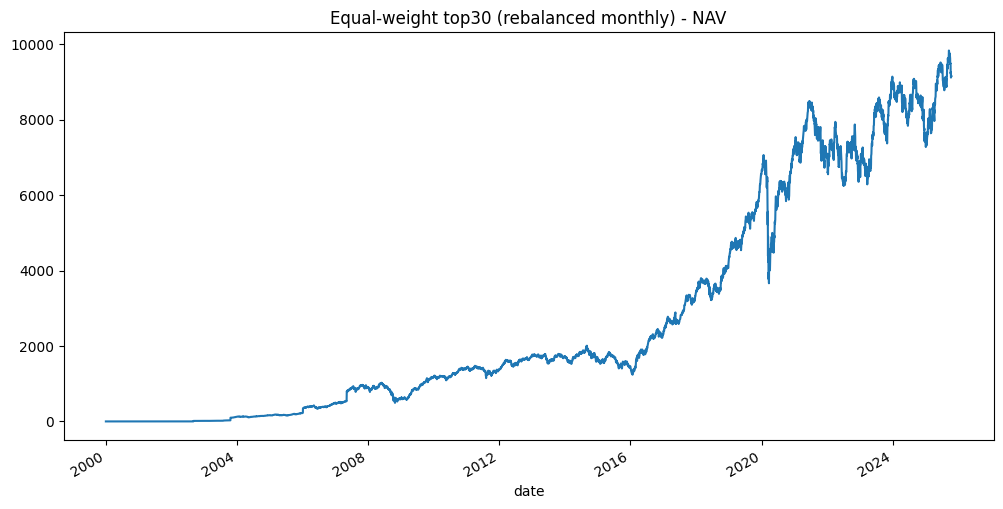

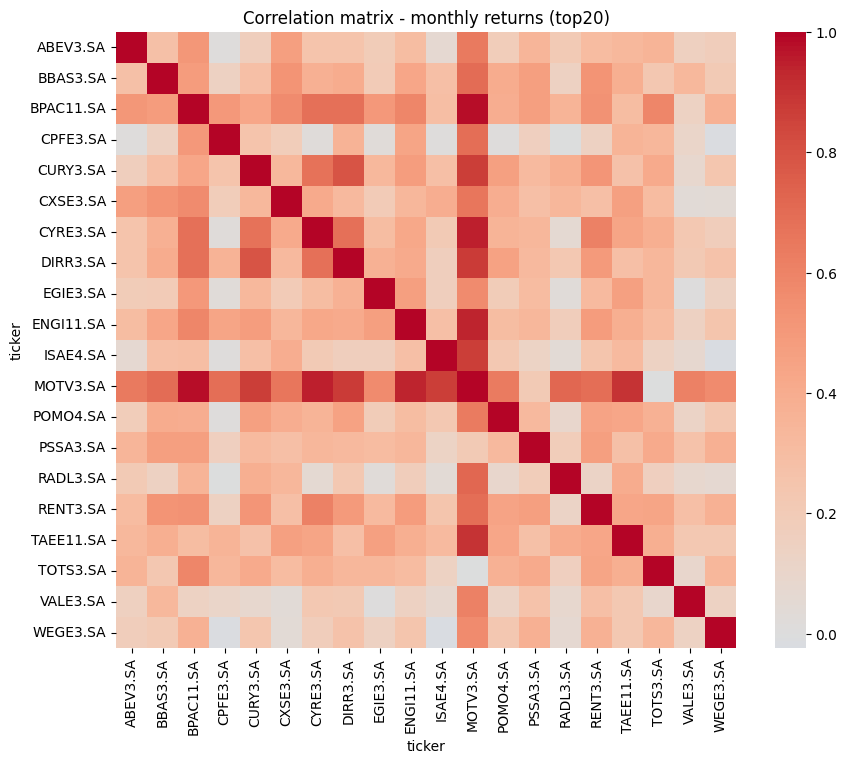

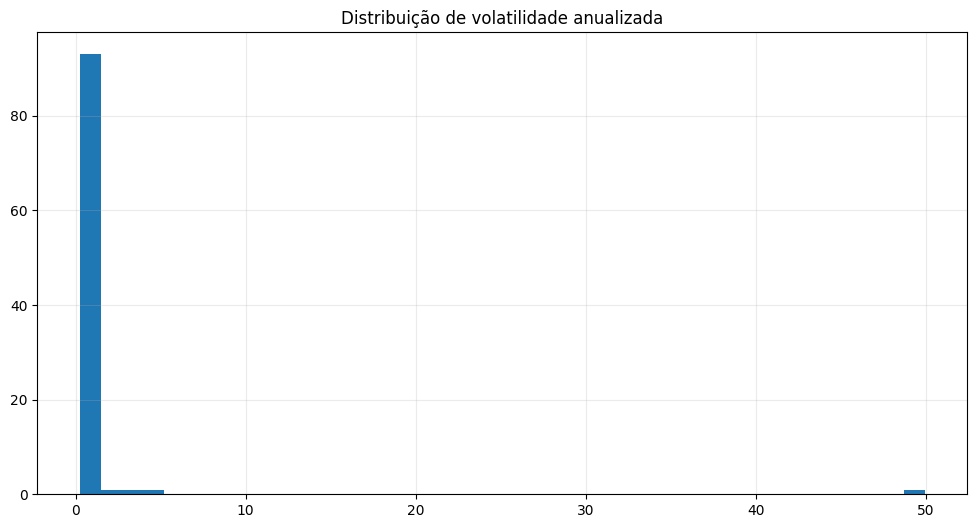

,ticker,n_obs,first,last,cagr,ann_return,ann_vol,sharpe,max_drawdown
69,RADL3.SA,6472,2000-01-06,2025-10-14,0.380822,0.610910,0.841870,0.725658,-0.623754
25,CURY3.SA,1262,2020-09-21,2025-10-14,0.356296,0.469278,0.391871,1.197531,-0.473148
11,BPAC11.SA,2152,2017-02-24,2025-10-14,0.352607,0.492482,0.435749,1.130195,-0.680142
49,ISAE4.SA,6426,2000-01-03,2025-10-14,0.315312,0.422311,0.392785,1.075169,-0.662012
19,CPFE3.SA,6475,2000-01-03,2025-10-14,0.255281,1.516271,3.603581,0.420768,-0.628743
95,WEGE3.SA,6475,2000-01-03,2025-10-14,0.251231,0.321061,0.331544,0.968381,-0.641985
75,RENT3.SA,5076,2005-05-23,2025-10-14,0.207686,0.324912,0.425716,0.763213,-0.767709
28,CYRE3.SA,6475,2000-01-03,2025-10-14,0.190039,0.338151,0.491055,0.688622,-0.809836
87,TOTS3.SA,4874,2006-03-09,2025-10-14,0.182423,0.266116,0.363732,0.731626,-0.497133
68,PSSA3.SA,5201,2004-11-22,2025-10-14,0.180839,0.237962,0.301045,0.790454,-0.622642


Saved stats_per_ticker_summary.csv


In [40]:
# =============================================================================
# notebook_analysis.py — Análise exploratória e métricas para parquets históricos
# =============================================================================
import os
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

# configs visuais (matplotlib)
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['grid.alpha'] = 0.25

HIST_DIR = Path("data/historical")
assert HIST_DIR.exists(), f"{HIST_DIR} não encontrado. Ajuste o caminho."

# ---------------------------
# 1) Função: carregar todos os parquets em um DataFrame longo
# ---------------------------
def load_all_parquets_to_long(hist_dir=HIST_DIR, tickers=None, date_col_candidates=('date','Date','index')):
    files = []
    if tickers:
        for t in tickers:
            p = hist_dir / f"{t}.parquet"
            if p.exists(): files.append(p)
    else:
        files = list(hist_dir.glob("*.parquet"))
    if not files:
        raise RuntimeError("Nenhum parquet encontrado em " + str(hist_dir))
    rows = []
    meta = []
    for f in tqdm(files, desc="Lendo parquets"):
        try:
            df = pd.read_parquet(f)
            # normalizar nome do ticker: inferir do arquivo se não existe
            ticker = f.stem
            df = df.copy()
            # garantir coluna date
            if 'date' not in df.columns and 'Date' in df.columns:
                df = df.rename(columns={'Date':'date'})
            if 'date' not in df.columns:
                # tentar inferir índice datetime
                if df.index.name and 'date' in df.index.name.lower():
                    df = df.reset_index()
                elif isinstance(df.index, pd.DatetimeIndex):
                    df = df.reset_index().rename(columns={df.index.name or 0:'date'})
                else:
                    # fallback: criar a coluna se não houver
                    raise RuntimeError(f"{f.name} não tem coluna 'date' detectada")
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            # garantir colunas básicas: Open, High, Low, Close, Adj Close, Volume
            expected = ['Open','High','Low','Close','Adj Close','Volume']
            # harmonizar nomes comuns (alguns parquets podem ter 'Adj Close' ou 'Adj_Close' ou 'Adj_Close')
            df_cols = {c: c for c in df.columns}
            # inserir ticker
            df['ticker'] = ticker
            rows.append(df)
            meta.append({'file':f.name, 'ticker':ticker, 'rows':len(df), 'start':df['date'].min(), 'end':df['date'].max()})
        except Exception as e:
            print("Falha lendo", f, e)
    big = pd.concat(rows, ignore_index=True, sort=False)
    # ordenar e remover duplicados exatos de (ticker,date)
    big = big.sort_values(['ticker','date']).drop_duplicates(subset=['ticker','date'], keep='last').reset_index(drop=True)
    return big, pd.DataFrame(meta)

# ---------------------------
# 2) Carregar dados (executar)
# ---------------------------
big, meta = load_all_parquets_to_long()
display(meta.head(20))
print("Total rows combined:", len(big))
print("Tickers combinados:", big['ticker'].nunique())

# ---------------------------
# 3) Checagem de qualidade básica
# ---------------------------
def quality_report(big_df):
    report = {}
    # por ticker: contagem, primeira, última data, gaps
    grp = big_df.groupby('ticker')
    r = grp['date'].agg(['min','max','count']).rename(columns={'min':'first','max':'last','count':'nrows'}).reset_index()
    r['period_days'] = (r['last'] - r['first']).dt.days
    # checar missing values por coluna (global)
    missing_global = big_df.isna().sum().sort_values(ascending=False)
    # checar número de datas únicas (padrão B3 ~dias úteis)
    date_counts = big_df.groupby('date')['ticker'].nunique().sort_values(ascending=False).head(10)
    report['by_ticker'] = r
    report['missing_global'] = missing_global
    report['top_dates_by_coverage'] = date_counts
    return report

qrep = quality_report(big)
display(qrep['by_ticker'].sort_values('nrows', ascending=False).head(20))
print("Missing (global):")
print(qrep['missing_global'])

# ---------------------------
# 4) Harmonização e preenchimento de colunas essenciais
# ---------------------------
def harmonize_columns(df):
    df = df.copy()
    # renomear variações
    colmap = {}
    for c in df.columns:
        low = c.lower().replace(" ", "").replace("_","")
        if low in ('adjclose','adj_close','adjustedclose'): colmap[c] = 'Adj Close'
        if low == 'close': colmap[c] = 'Close'
        if low == 'open': colmap[c] = 'Open'
        if low == 'high': colmap[c] = 'High'
        if low == 'low': colmap[c] = 'Low'
        if low in ('volume','vol'): colmap[c] = 'Volume'
        if low in ('dividends','dividend'): colmap[c] = 'Dividends'
        if low in ('stocksplits','stock_splits','splits'): colmap[c] = 'Stock Splits'
    df = df.rename(columns=colmap)
    # garantir colunas existam; se não, criar com NaN
    for c in ['Open','High','Low','Close','Adj Close','Volume','Dividends','Stock Splits']:
        if c not in df.columns:
            df[c] = np.nan
    return df

big = harmonize_columns(big)

# ---------------------------
# 5) Calcular retornos diários por ticker
# ---------------------------
def compute_returns(df):
    df = df.copy()
    # ordenar
    df = df.sort_values(['ticker','date']).reset_index(drop=True)
    # group by ticker and compute pct_change on 'Adj Close' preferencialmente
    price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
    df['price_used'] = df[price_col]
    df['ret_daily'] = df.groupby('ticker')['price_used'].pct_change()
    # log returns
    df['ret_log'] = np.log1p(df['ret_daily'])
    # forward returns (useful for target creation): next 1M, 3M, 6M, 12M (approx business days)
    df['ret_1d_forward'] = df.groupby('ticker')['price_used'].pct_change(periods=-1) * -1  # simpler to compute later if needed
    return df

big = compute_returns(big)

# ---------------------------
# 6) Estatísticas descritivas por ticker
# ---------------------------
def stats_per_ticker(df, trading_days_per_year=252):
    out = []
    for t, g in df.groupby('ticker'):
        g = g.dropna(subset=['price_used']).sort_values('date')
        if g.shape[0] < 2:
            continue
        daily_rets = g['ret_daily'].dropna()
        mean_daily = daily_rets.mean()
        vol_daily = daily_rets.std()
        # anualizar
        ann_return = (1 + mean_daily) ** trading_days_per_year - 1
        ann_vol = vol_daily * np.sqrt(trading_days_per_year)
        # CAGR (usando price series)
        try:
            start_p = g['price_used'].iloc[0]
            end_p = g['price_used'].iloc[-1]
            days = (g['date'].iloc[-1] - g['date'].iloc[0]).days
            years = days / 365.25 if days>0 else np.nan
            cagr = (end_p / start_p) ** (1/years) - 1 if years and years>0 else np.nan
        except Exception:
            cagr = np.nan
        sharpe = ann_return / ann_vol if ann_vol>0 else np.nan
        maxdd = calculate_max_drawdown(g['price_used'])
        out.append({'ticker': t, 'n_obs': len(g), 'first': g['date'].iloc[0], 'last': g['date'].iloc[-1],
                    'cagr': cagr, 'ann_return': ann_return, 'ann_vol': ann_vol, 'sharpe': sharpe, 'max_drawdown': maxdd})
    return pd.DataFrame(out).sort_values('cagr', ascending=False)

def calculate_max_drawdown(price_series):
    # price_series: pd.Series indexed by sequential time (not necessarily datetime index)
    p = price_series.fillna(method='ffill').dropna()
    if p.empty: return np.nan
    running_max = p.cummax()
    dd = (p / running_max) - 1
    return dd.min()  # negativo (ex: -0.45)

stats_df = stats_per_ticker(big)
display(stats_df.head(30))

# ---------------------------
# 7) Curvas de capital (portfolio equal-weighted example)
# ---------------------------
def build_equal_weight_portfolio(df, tickers_list=None, start_date=None, rebalance='M'):
    """
    Constrói série de capital de um portfolio equal-weighted rebalanced mensalmente (ou 'M' para mês).
    df deve ter columns ['ticker','date','price_used'] com retornos já calculados.
    """
    df = df.copy()
    df = df.dropna(subset=['price_used'])
    if start_date:
        df = df[df['date']>=pd.to_datetime(start_date)]
    # pivot price series: index date, columns ticker
    pivot = df.pivot_table(index='date', columns='ticker', values='price_used')
    pivot = pivot.sort_index().ffill().dropna(how='all')
    # compute returns daily
    rets = pivot.pct_change().fillna(0)
    # monthly rebalance: create monthly periods
    if rebalance == 'M':
        # get month start labels
        month_groups = pivot.resample('M').last().index
        # simple approach: on each month-start allocate equal weights across available tickers
        weights = {}
        for dt in month_groups:
            # available at month end
            avail = pivot.loc[:dt].iloc[-1].dropna().index.tolist()
            w = pd.Series(1/len(avail), index=avail) if avail else pd.Series()
            weights[dt] = w
        # generate daily weight series by forward filling
        weight_df = pd.DataFrame(index=pivot.index, columns=pivot.columns, data=0.0)
        last_w = None
        for d in weight_df.index:
            # find last month end <= d
            key = max([k for k in weights.keys() if k<=d], default=None)
            if key is not None:
                w = weights[key]
                for col in weight_df.columns:
                    weight_df.at[d,col] = w.get(col, 0.0)
        # compute portfolio daily returns
        port_daily = (rets * weight_df).sum(axis=1)
        port_nav = (1 + port_daily).cumprod()
        return port_nav
    else:
        raise NotImplementedError("Only 'M' rebalance implemented in this util.")

# exemplo: top 30 tickers by cagr
top_tickers = stats_df.head(30)['ticker'].tolist()
port_nav = build_equal_weight_portfolio(big, tickers_list=top_tickers, start_date=None, rebalance='M')
port_nav.plot(title="Equal-weight top30 (rebalanced monthly) - NAV");

# ---------------------------
# 8) Heatmap de correlação (retornos mensais)
# ---------------------------
def monthly_rets_pivot(df, tickers_select=None):
    df = df.copy()
    df = df.dropna(subset=['price_used'])
    if tickers_select:
        df = df[df['ticker'].isin(tickers_select)]
    pivot = df.pivot_table(index='date', columns='ticker', values='price_used').sort_index()
    # resample to month end and compute pct_change
    monthly_close = pivot.resample('M').last()
    monthly_rets = monthly_close.pct_change().dropna(how='all')
    return monthly_rets

monthly = monthly_rets_pivot(big, tickers_select=top_tickers[:20])
corr = monthly.corr()
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation matrix - monthly returns (top20)")
plt.show()

# ---------------------------
# 9) Visualizações e inspeções rápidas
# ---------------------------
# - Histogram of annualized vol
plt.figure()
stats_df['ann_vol'].dropna().hist(bins=40)
plt.title("Distribuição de volatilidade anualizada")
plt.show()

# - Top 10 by CAGR
display(stats_df.sort_values('cagr', ascending=False).head(10))

# - Save stats to csv
stats_df.to_csv("stats_per_ticker_summary.csv", index=False)
print("Saved stats_per_ticker_summary.csv")


In [42]:
import pandas as pd

df = pd.read_csv("stats_per_ticker_summary.csv")
df.head()


,ticker,n_obs,first,last,cagr,ann_return,ann_vol,sharpe,max_drawdown
0,RADL3.SA,6472,2000-01-06,2025-10-14,0.380822,0.610910,0.841870,0.725658,-0.623754
1,CURY3.SA,1262,2020-09-21,2025-10-14,0.356296,0.469278,0.391871,1.197531,-0.473148
2,BPAC11.SA,2152,2017-02-24,2025-10-14,0.352607,0.492482,0.435749,1.130195,-0.680142
3,ISAE4.SA,6426,2000-01-03,2025-10-14,0.315312,0.422311,0.392785,1.075169,-0.662012
4,CPFE3.SA,6475,2000-01-03,2025-10-14,0.255281,1.516271,3.603581,0.420768,-0.628743


In [43]:
df.describe()


,n_obs,cagr,ann_return,ann_vol,sharpe,max_drawdown
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,4097.886598,0.053343,2054.035107,1.029295,41.531624,-0.744035
std,2068.204353,0.137794,20227.855462,5.046486,404.888896,0.182326
min,123.000000,-0.392941,-0.317738,0.234200,-0.731061,-1.000000
25%,1940.000000,-0.012162,0.123542,0.368787,0.299725,-0.890000
50%,4428.000000,0.069484,0.188661,0.416510,0.425555,-0.765216
75%,6474.000000,0.142455,0.237962,0.502039,0.605666,-0.625428
max,6475.000000,0.380822,199221.479624,49.953814,3988.113503,-0.120172


In [44]:
# Top 10 pelo índice de Sharpe
df.nlargest(10, "sharpe")[["ticker", "sharpe", "ann_return", "ann_vol", "max_drawdown"]]

# Top 10 pelo CAGR
df.nlargest(10, "cagr")[["ticker", "cagr", "ann_return", "ann_vol"]]


,ticker,cagr,ann_return,ann_vol
0,RADL3.SA,0.380822,0.610910,0.841870
1,CURY3.SA,0.356296,0.469278,0.391871
2,BPAC11.SA,0.352607,0.492482,0.435749
3,ISAE4.SA,0.315312,0.422311,0.392785
4,CPFE3.SA,0.255281,1.516271,3.603581
5,WEGE3.SA,0.251231,0.321061,0.331544
6,RENT3.SA,0.207686,0.324912,0.425716
7,CYRE3.SA,0.190039,0.338151,0.491055
8,TOTS3.SA,0.182423,0.266116,0.363732
9,PSSA3.SA,0.180839,0.237962,0.301045


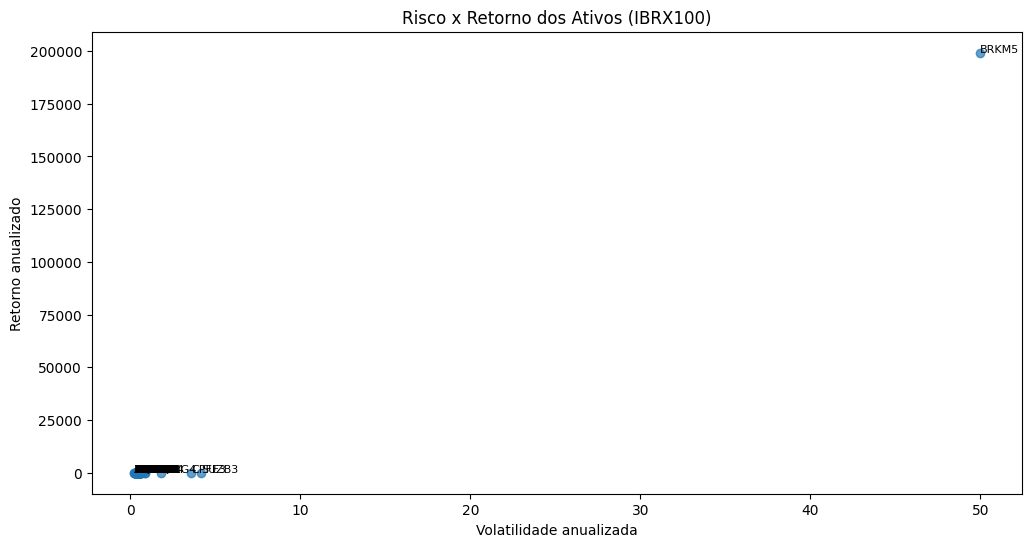

In [45]:
import matplotlib.pyplot as plt

plt.scatter(df["ann_vol"], df["ann_return"], alpha=0.7)
for _, row in df.iterrows():
    plt.text(row["ann_vol"], row["ann_return"], row["ticker"].replace(".SA", ""), fontsize=8)
plt.xlabel("Volatilidade anualizada")
plt.ylabel("Retorno anualizado")
plt.title("Risco x Retorno dos Ativos (IBRX100)")
plt.show()


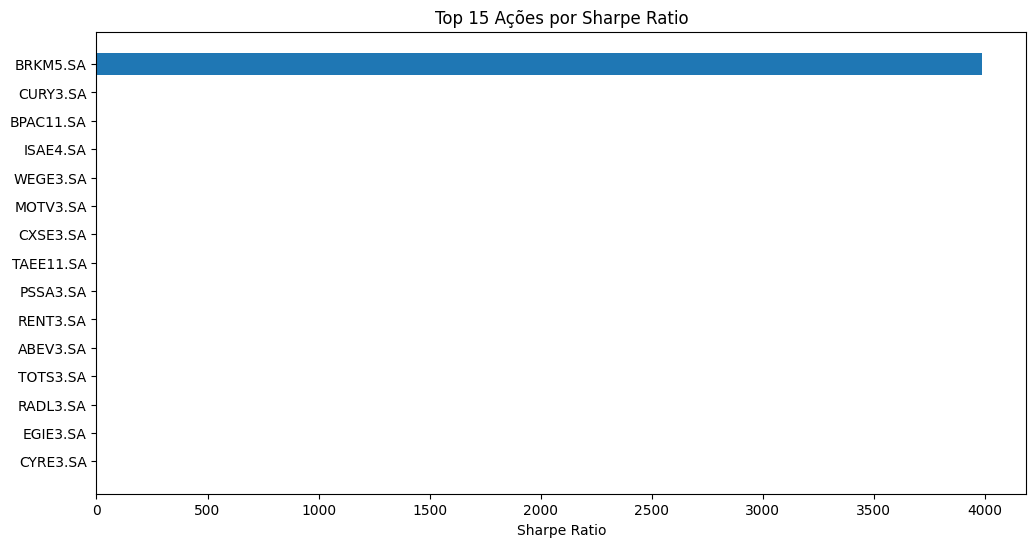

In [46]:
top = df.sort_values("sharpe", ascending=False).head(15)
plt.barh(top["ticker"], top["sharpe"])
plt.gca().invert_yaxis()
plt.xlabel("Sharpe Ratio")
plt.title("Top 15 Ações por Sharpe Ratio")
plt.show()


In [56]:
# fundamental_data_extractor.py
import pandas as pd
import os
import logging
from tqdm import tqdm
import fundamentus

# Configuração do logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

# Diretório para salvar os dados
DATA_DIR = "data"
FUNDAMENTAL_DIR = os.path.join(DATA_DIR, "fundamental")
os.makedirs(FUNDAMENTAL_DIR, exist_ok=True)

def load_tickers_from_csv(file_path: str) -> list:
    """Carrega a lista de tickers a partir de um arquivo CSV."""
    if not os.path.exists(file_path):
        logging.error(f"Arquivo de tickers não encontrado em: {file_path}")
        return []
    
    df = pd.read_csv(file_path)
    
    # Heurística para encontrar a coluna de tickers
    if 'Ticker' in df.columns:
        tickers = df['Ticker'].dropna().astype(str).tolist()
    else:
        tickers = df.iloc[:, 0].dropna().astype(str).tolist()
        
    # Normaliza para o formato que `fundamentus` espera (ex: 'PETR4' sem '.SA')
    tickers_normalized = [t.replace('.SA', '') for t in tickers]
    logging.info(f"{len(tickers_normalized)} tickers carregados de {file_path}")
    return tickers_normalized

# fundamental_data_extractor.py -> Função get_fundamental_data atualizada

def get_fundamental_data(tickers: list) -> pd.DataFrame:
    """
    Busca dados fundamentalistas para uma lista de tickers usando a biblioteca fundamentus.
    Inclui uma etapa de sanitização para lidar com valores que são listas ou Series.
    Retorna um único DataFrame com todos os dados.
    """
    if not tickers:
        logging.warning("A lista de tickers está vazia. Nenhum dado será buscado.")
        return pd.DataFrame()

    all_data = []
    
    logging.info("Iniciando a captura de dados fundamentalistas...")
    for ticker in tqdm(tickers, desc="Buscando dados fundamentalistas"):
        try:
            data = fundamentus.get_detalhes_papel(ticker)
            data['ticker'] = ticker
            all_data.append(data)
        except Exception as e:
            logging.warning(f"Não foi possível obter dados para o ticker {ticker}. Erro: {e}")
            continue
            
    if not all_data:
        logging.error("Nenhum dado fundamentalista foi capturado com sucesso.")
        return pd.DataFrame()

    # --- INÍCIO DA CORREÇÃO (AGORA MAIS ROBUSTA) ---
    # Etapa de Sanitização: Converte valores que são listas, tuplas ou Series em strings.
    sanitized_data = []
    for company_data in all_data:
        sanitized_item = {}
        for key, value in company_data.items():
            if isinstance(value, (list, tuple)):
                # Se o valor for uma lista, une seus elementos em uma única string
                sanitized_item[key] = ' / '.join(map(str, value))
            
            # ADICIONADO: Verifica também se o valor é uma Series do pandas
            elif isinstance(value, pd.Series):
                # Converte a Series para uma lista de strings e depois une
                sanitized_item[key] = ' / '.join(value.astype(str).tolist())
                
            else:
                # Caso contrário, mantém o valor original
                sanitized_item[key] = value
        sanitized_data.append(sanitized_item)
    # --- FIM DA CORREÇÃO ---

    # Converte a lista SANITIZADA de dicionários em um DataFrame
    df_fundamental = pd.DataFrame(sanitized_data)
    
    # Reordena as colunas para ter 'ticker' primeiro
    if 'ticker' in df_fundamental.columns:
        cols = ['ticker'] + [col for col in df_fundamental.columns if col != 'ticker']
        df_fundamental = df_fundamental[cols]
        
    return df_fundamental

if __name__ == "__main__":
    # 1. Carregar os tickers do arquivo CSV gerado anteriormente
    tickers_csv_path = "tickers_ibrx100_full.csv"
    ibrx_tickers = load_tickers_from_csv(tickers_csv_path)
    
    # 2. Buscar os dados fundamentalistas
    df_fund = get_fundamental_data(ibrx_tickers)
    
    # 3. Salvar os resultados
    if not df_fund.empty:
        output_path_parquet = os.path.join(FUNDAMENTAL_DIR, "fundamentus_data.parquet")
        output_path_csv = os.path.join(FUNDAMENTAL_DIR, "fundamentus_data.csv")
        
        # Salva em Parquet (preferencial)
        df_fund.to_parquet(output_path_parquet, index=False)
        logging.info(f"Dados fundamentalistas salvos em: {output_path_parquet}")
        
        # Salva também em CSV para fácil visualização
        df_fund.to_csv(output_path_csv, index=False)
        logging.info(f"Dados fundamentalistas salvos também em: {output_path_csv}")
        
        print("\n--- Amostra dos Dados Coletados ---")
        print(df_fund.head())
        print(f"\nDimensões do DataFrame: {df_fund.shape}")

2025-10-15 12:17:27,584 INFO 97 tickers carregados de tickers_ibrx100_full.csv
2025-10-15 12:17:27,586 INFO Iniciando a captura de dados fundamentalistas...
Buscando dados fundamentalistas: 100%|██████████| 97/97 [00:05<00:00, 18.08it/s]
2025-10-15 12:17:33,829 INFO Dados fundamentalistas salvos em: data\fundamental\fundamentus_data.parquet
2025-10-15 12:17:33,834 INFO Dados fundamentalistas salvos também em: data\fundamental\fundamentus_data.csv



--- Amostra dos Dados Coletados ---
  ticker  Papel   Tipo       Empresa                    Setor  \
0  ALOS3  ALOS3     ON      ALLOS ON    Exploração de Imóveis   
1  ABEV3  ABEV3     ON  AMBEV S/A ON                  Bebidas   
2  ANIM3  ANIM3  ON NM   ANIMA ON NM                 Diversos   
3  ASAI3  ASAI3  ON NM   ASSAI ON NM  Comércio e Distribuição   
4  AURE3  AURE3  ON NM   AUREN ON NM         Energia Elétrica   

                   Subsetor Cotacao Data_ult_cot Min_52_sem Max_52_sem  ...  \
0     Exploração de Imóveis   23.79   2025-10-14      16.48      25.86  ...   
1  Cervejas e Refrigerantes   12.05   2025-10-14      10.52      14.29  ...   
2     Serviços Educacionais    3.12   2025-10-14       1.49       4.44  ...   
3                 Alimentos    8.19   2025-10-14       5.06      11.86  ...   
4          Energia Elétrica   10.46   2025-10-14       7.34      11.06  ...   

  Lucro_Liquido_12m Receita_Liquida_3m     EBIT_3m Lucro_Liquido_3m  \
0         737411000       